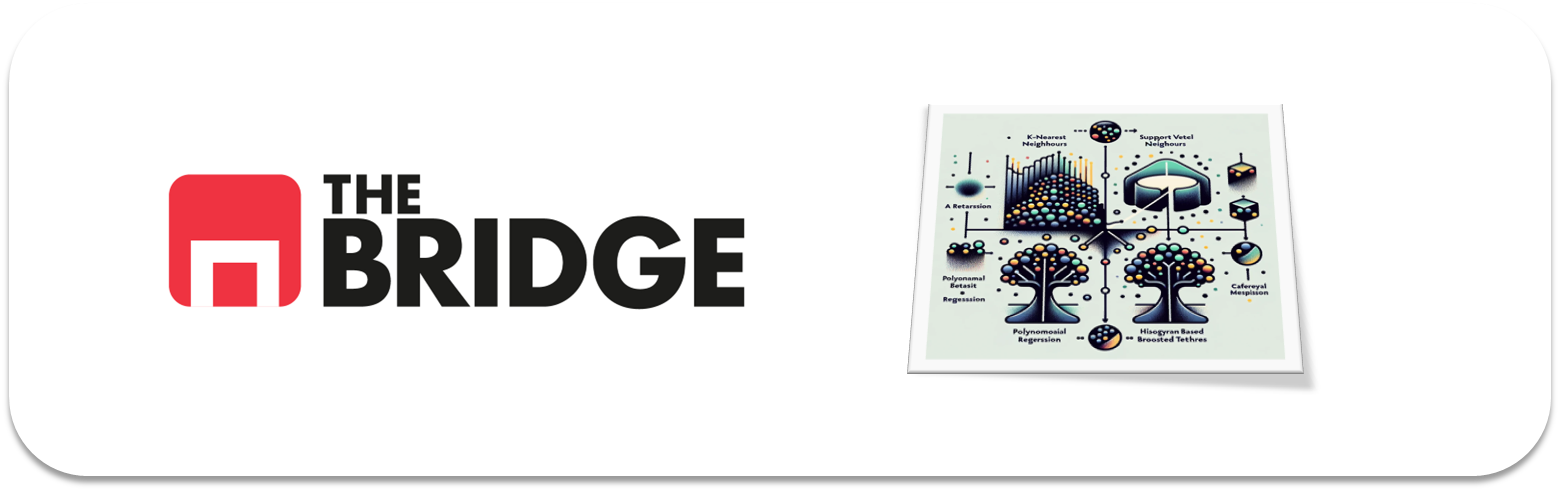

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split 

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler





### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [14]:
df = pd.read_csv("./data/credit_npo.csv")
df.head(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [16]:
#Cardinalidad funcion
def cardinalidad(df,categoria = 10, continua = 30):
    # Nuevo df con columnas, cardinalidades, % variación cardinalidad, tipo de dato y variables
    df_cardi = pd.DataFrame([df.columns, df.nunique(), df.nunique()/len(df) * 100, df.dtypes])
    df_cardi = df_cardi.T 
    df_cardi = df_cardi.rename(columns = {0:"Columnas" , 1:"Cardinalidad", 2: "Porcentaje_Cardi", 3: "Tipo_dato"}) 

    # Corrección para cuando solo tengo un valor
    df_cardi.loc[df_cardi["Cardinalidad"] == 1, "Porcentaje_Cardi"] = 0.00

    # Tipo de variables
    df_cardi["Variable"] = "Categorica"
    df_cardi.loc[df_cardi["Cardinalidad"] == 2, "Variable"] = "Binaria"
    df_cardi.loc[df_cardi["Cardinalidad"] >= categoria, "Variable"] = "Numerica discreta"
    df_cardi.loc[df_cardi["Porcentaje_Cardi"] >= continua, "Variable"] = "Numerica continua"

    return df_cardi

In [17]:
cardinalidad(df)

,Columnas,Cardinalidad,Porcentaje_Cardi,Tipo_dato,Variable
0,SeriousDlqin2yrs,2,0.015953,int64,Binaria
1,RevolvingUtilizationOfUnsecuredLines,10764,85.857861,float64,Numerica continua
2,age,78,0.622158,int64,Numerica discreta
3,NumberOfTime30-59DaysPastDueNotWorse,10,0.079764,int64,Numerica discreta
4,DebtRatio,11547,92.103374,float64,Numerica continua
5,MonthlyIncome,4167,33.237617,float64,Numerica continua
6,NumberOfOpenCreditLinesAndLoans,43,0.342985,int64,Numerica discreta
7,NumberOfTimes90DaysLate,13,0.103693,int64,Numerica discreta
8,NumberRealEstateLoansOrLines,16,0.127622,int64,Numerica discreta
9,NumberOfTime60-89DaysPastDueNotWorse,8,0.063811,int64,Categorica


In [58]:
#Tratamos los valores nulos
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

In [60]:
cardinalidad(df) #Parece que quitar los nulos no afecta mucho

,Columnas,Cardinalidad,Porcentaje_Cardi,Tipo_dato,Variable
0,SeriousDlqin2yrs,2,0.016926,int64,Binaria
1,RevolvingUtilizationOfUnsecuredLines,10314,87.288422,float64,Numerica continua
2,age,78,0.660122,int64,Numerica discreta
3,NumberOfTime30-59DaysPastDueNotWorse,10,0.084631,int64,Numerica discreta
4,DebtRatio,11472,97.088693,float64,Numerica continua
5,MonthlyIncome,4167,35.265741,float64,Numerica continua
6,NumberOfOpenCreditLinesAndLoans,43,0.363913,int64,Numerica discreta
7,NumberOfTimes90DaysLate,13,0.11002,int64,Numerica discreta
8,NumberRealEstateLoansOrLines,16,0.13541,int64,Numerica discreta
9,NumberOfTime60-89DaysPastDueNotWorse,8,0.067705,int64,Categorica


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

In [18]:
#Queremos saber quien tendrá dificultad económica por lo que el target debe ser: SeriousDlqin2yrs
#Es binaria, 0 pagador, 1 deudor. El dato que queremos predecir son los 1 (deudores)

#Queremos averiguar una CATEGORIA.


### #1.3
Pinta la distribución de frecuencias del target y coméntala

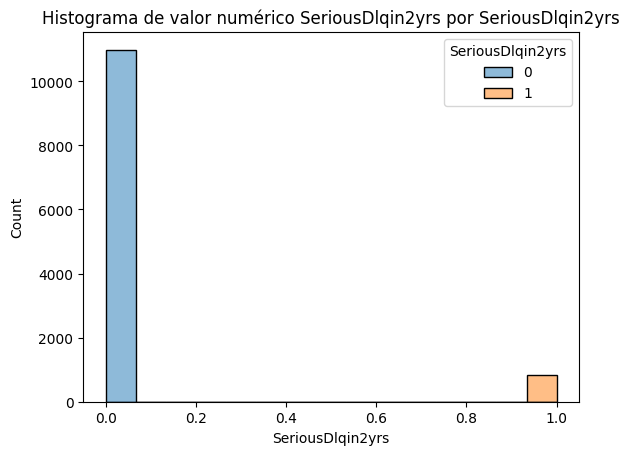

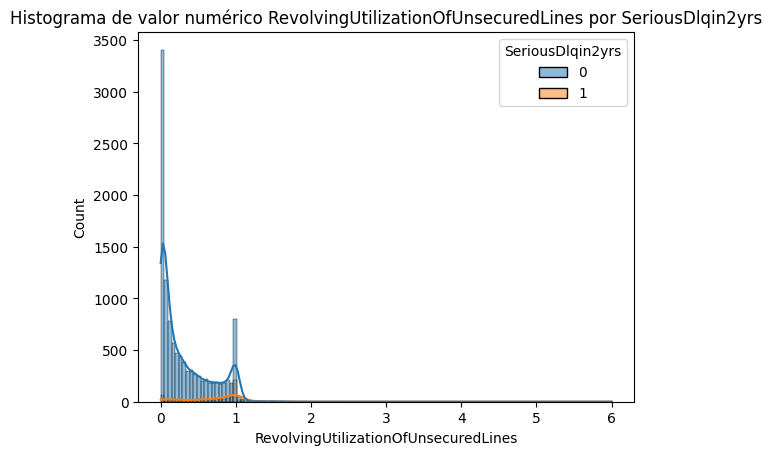

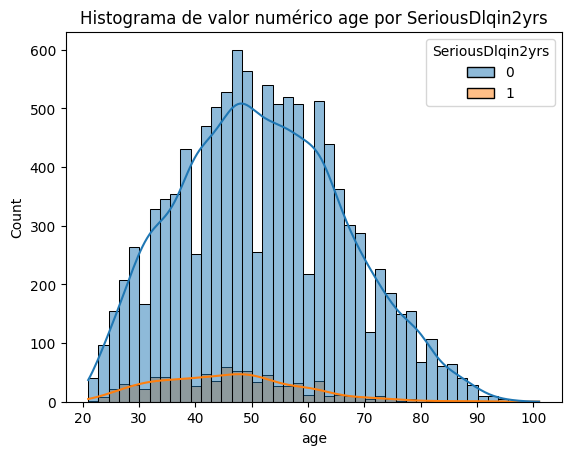

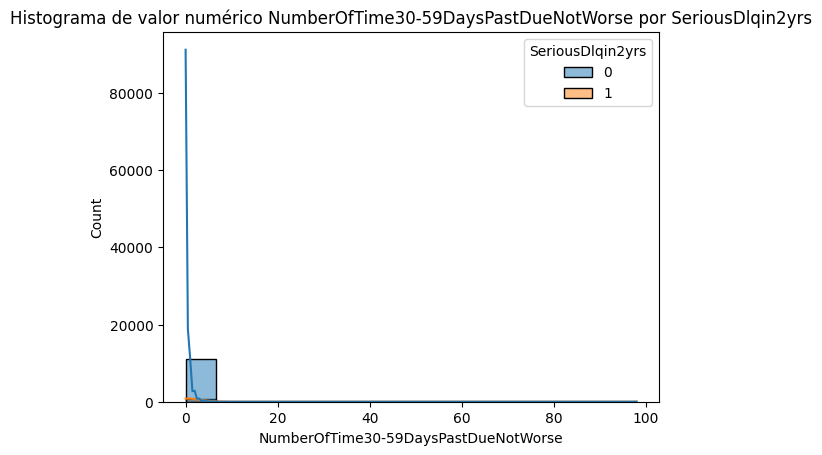

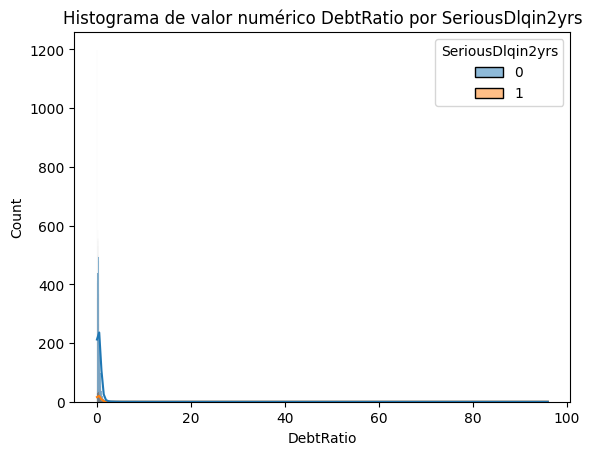

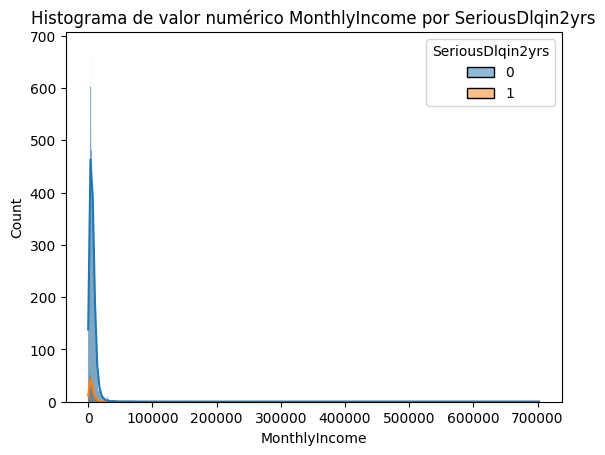

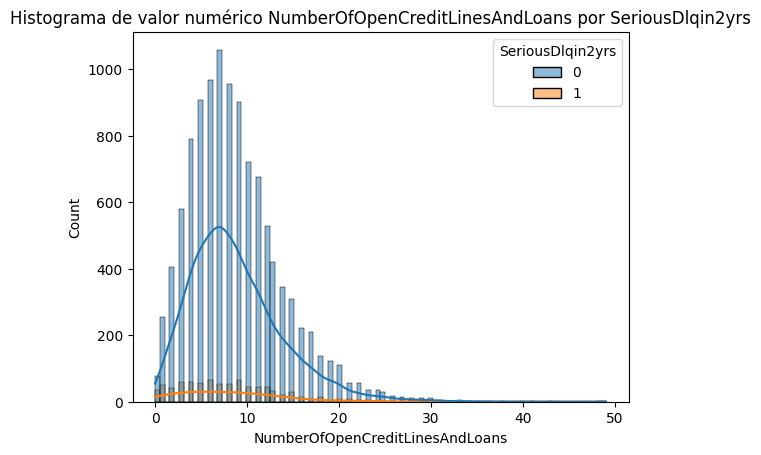

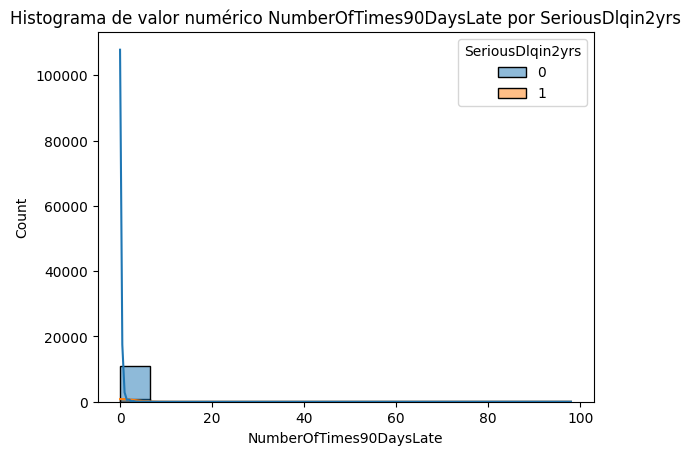

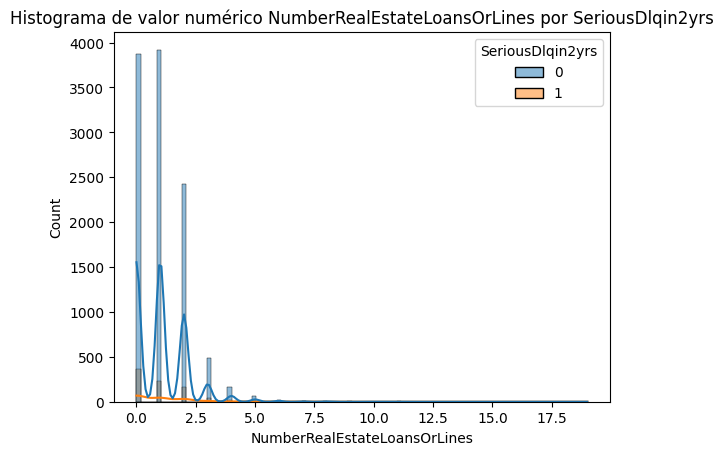

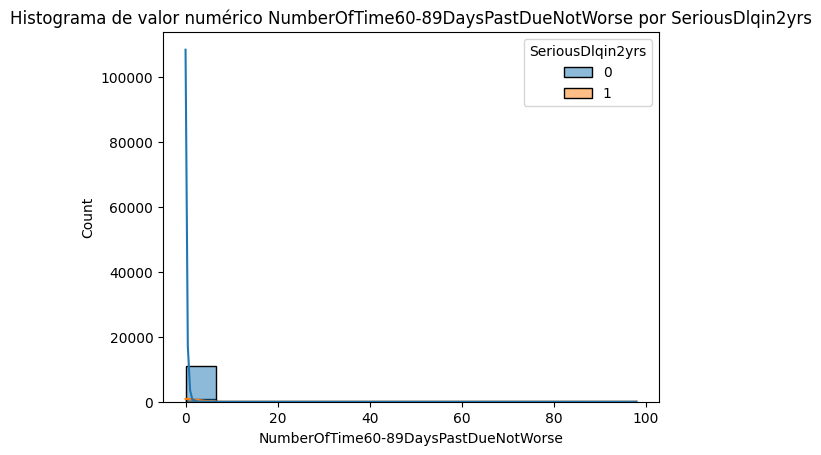

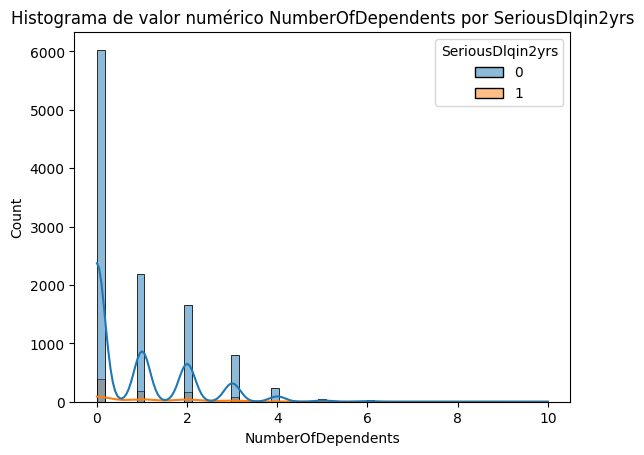

In [75]:
target = "SeriousDlqin2yrs"
for col in df.columns:
    sns.histplot(data=df, x=col, hue=target, kde=True, stat="count", common_norm=False)
    plt.title(f"Histograma de valor numérico {col} por {target}")
    plt.show()


#Parece que el dataset esta desequilibrado. Casi todos los datos son de "pagadores"
#Las graficas que me parecen relevantes son:

#  NumberOfTime30-59DaysPastDueNotWorse
# NumberOfTime60-89DaysPastDueNotWorse	
#  NumberOfTimes90DaysLate
#  NumberRealEstateLoansOrLines 
#  NumberOfDependents


### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [108]:
features = ["NumberOfTime30-59DaysPastDueNotWorse","NumberOfTime60-89DaysPastDueNotWorse","NumberOfTimes90DaysLate","NumberOfDependents"]

In [109]:
#Dividimos el data set
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42) 

In [110]:
from sklearn.utils import resample
#Hacemos un equilibrado del dataset, con Under Sampling
#Separar las clases mayoritaria y minoritaria
clase_mayoritaria = X_train[y_train == 0]
clase_minoritaria = X_train[y_train == 1]

# Bajomuestrear la clase mayoritaria
clase_mayoritaria_bajomuestreo = resample(clase_mayoritaria,
                                          replace=False,
                                          n_samples=len(clase_minoritaria),  # igual al número de la clase minoritaria
                                          random_state=42)

# Combinar la clase minoritaria con la clase mayoritaria bajomuestreada (importante es que resample mantiene los índices para que lo que viene a continuación tenga sentido)
X_train_bajomuestreo = pd.concat([clase_mayoritaria_bajomuestreo, clase_minoritaria])
y_train_bajomuestreo = pd.concat([y_train.loc[clase_mayoritaria_bajomuestreo.index], 
                                  y_train.loc[clase_minoritaria.index]])

array([[<Axes: title={'center': 'NumberOfTime30-59DaysPastDueNotWorse'}>,
        <Axes: title={'center': 'NumberOfTime60-89DaysPastDueNotWorse'}>],
       [<Axes: title={'center': 'NumberOfTimes90DaysLate'}>,
        <Axes: title={'center': 'NumberOfDependents'}>]], dtype=object)

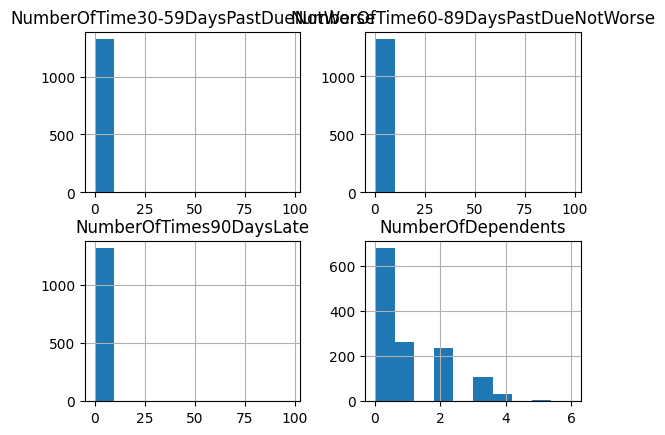

In [111]:
X_train_bajomuestreo.hist()

In [112]:
#MODELO REGRESION LOGISTICA BINARIA
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 5000)

log_reg.fit(X_train_bajomuestreo, y_train_bajomuestreo)

LogisticRegression(max_iter=5000)

In [113]:
intercept = log_reg.intercept_
coefs = log_reg.coef_.ravel()
df_features = pd.DataFrame(coefs, X_train_bajomuestreo.columns, columns=['coefficient']).copy()
df_features['coefficient'] = np.abs(df_features['coefficient'])
df_features.sort_values('coefficient', ascending=False).head()

,coefficient
NumberOfTimes90DaysLate,1.143059
NumberOfTime60-89DaysPastDueNotWorse,0.659558
NumberOfTime30-59DaysPastDueNotWorse,0.641687
NumberOfDependents,0.088308


In [114]:
#MODELO REGRESION LOGISTICA BINARIA
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 5000)

log_reg.fit(X_train_bajomuestreo, y_train_bajomuestreo)

LogisticRegression(max_iter=5000)

In [116]:
#PREDICCION 
from sklearn.metrics import accuracy_score

acc_train = round(accuracy_score(log_reg.predict(X_train_bajomuestreo), y_train_bajomuestreo), 3)
acc_test = round(accuracy_score(log_reg.predict(X_test), y_test), 3)

print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)

Accuracy train: 0.715
Accuracy test: 0.868


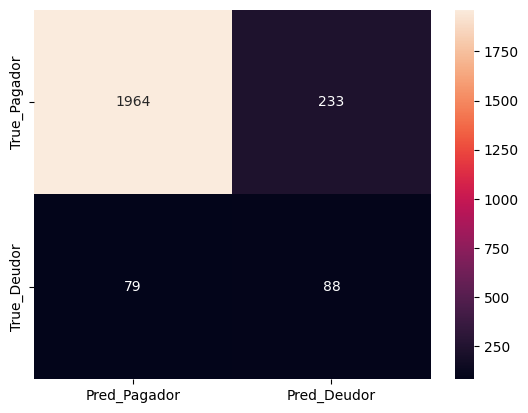

In [117]:
#MATRIZ DE CONFUSION
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_test, log_reg.predict(X_test))

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pagador', 'Pred_Deudor'],
                          index = ['True_Pagador', 'True_Deudor'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

In [118]:
#REPORTE DE CLASIFICACION 
from sklearn.metrics import classification_report
from pprint import pprint

print(classification_report(y_test, log_reg.predict(X_test)))

#NO NOS ADIVINA NADA XD

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      2197
           1       0.27      0.53      0.36       167

    accuracy                           0.87      2364
   macro avg       0.62      0.71      0.64      2364
weighted avg       0.91      0.87      0.89      2364



In [120]:
# MODELO 2 RANDOM FOREST CLASSIFIER

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state= 42)
rf_clf.fit(X_train_bajomuestreo, y_train_bajomuestreo)
y_pred = rf_clf.predict(X_train_bajomuestreo)  # Puedes usar X_test si tienes datos de prueba.

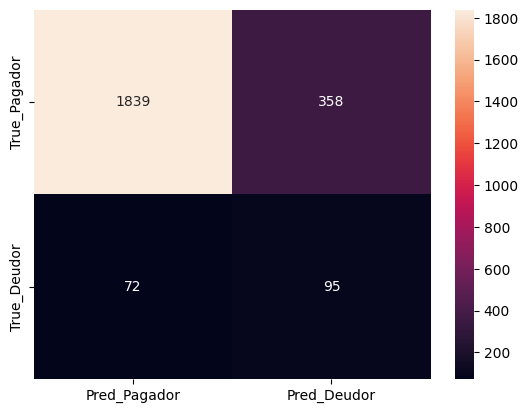

In [121]:
c_matrix = confusion_matrix(y_test, rf_clf.predict(X_test))

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pagador', 'Pred_Deudor'],
                          index = ['True_Pagador', 'True_Deudor'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

In [122]:
print(classification_report(y_test, rf_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      2197
           1       0.21      0.57      0.31       167

    accuracy                           0.82      2364
   macro avg       0.59      0.70      0.60      2364
weighted avg       0.91      0.82      0.85      2364



In [129]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_bajomuestreo,y_train_bajomuestreo)
y_pred = knn.predict(X_train)  # Puedes usar X_test si tienes datos de prueba.

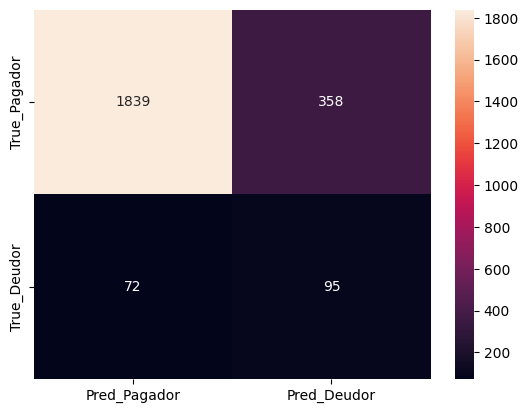

In [130]:
c_matrix = confusion_matrix(y_test, rf_clf.predict(X_test))

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pagador', 'Pred_Deudor'],
                          index = ['True_Pagador', 'True_Deudor'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

In [131]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2197
           1       0.26      0.51      0.35       167

    accuracy                           0.86      2364
   macro avg       0.61      0.70      0.63      2364
weighted avg       0.91      0.86      0.88      2364



In [134]:
#COMPARAR MODELOS: VALIDACION CRUZADA
from sklearn.model_selection import cross_val_score
model_set = [knn, rf_clf, log_reg]
metricas_cv = {}
valores = []
for modelo in model_set:
        metricas_cv[modelo] = cross_val_score(modelo, X_train_bajomuestreo, y_train_bajomuestreo, cv = 3, scoring = "accuracy")
        valores.append(np.mean(metricas_cv[modelo]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]


for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(valores)}")
print(f"El ganador es {ganador}")


Model <KNeighborsClassifier(n_neighbors=20)>, Accuracy_CV: 0.7141779788838613
Model <RandomForestClassifier(random_state=42)>, Accuracy_CV: 0.7345399698340875
Model <LogisticRegression(max_iter=5000)>, Accuracy_CV: 0.7149321266968326
El ganador es RandomForestClassifier(random_state=42)


In [136]:
#OPTIMIZACIÓN: AJUSTE DE HIPERPARÁMETROS

from sklearn.model_selection import GridSearchCV
params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= params_grid,
                       cv = 3,
                       scoring = "accuracy",
                       n_jobs = -1)

rf_grid.fit(X_train_bajomuestreo, y_train_bajomuestreo)


# ANALISIS DE ERRORES

#No hay mucha precision con ninguno de los modelos.

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'min_samples_leaf': [10, 20, 40],
                         'n_estimators': [100, 200, 400]},
             scoring='accuracy')

In [137]:
print(classification_report(y_test, rf_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      2197
           1       0.20      0.61      0.30       167

    accuracy                           0.80      2364
   macro avg       0.58      0.71      0.59      2364
weighted avg       0.91      0.80      0.84      2364



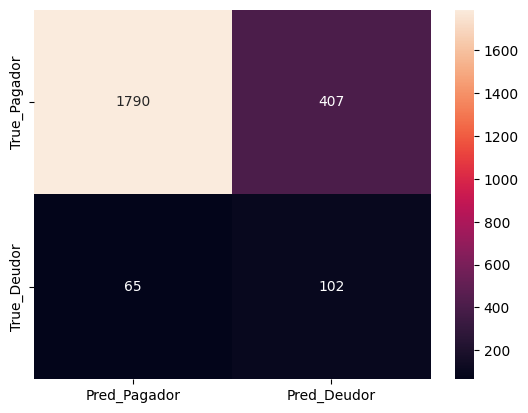

In [138]:
c_matrix = confusion_matrix(y_test, rf_grid.predict(X_test))

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pagador', 'Pred_Deudor'],
                          index = ['True_Pagador', 'True_Deudor'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');